In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc, recall_score, precision_score,f1_score,roc_auc_score
from xgboost import XGBClassifier

In [3]:
data = pd.read_csv('../data/raw/creditcard.csv.zip')
pd.options.display.max_columns = 32
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
def remove_outlier(col):
  sorted(col)
  Q1,Q3 = col.quantile([0.25,0.75])
  IQR = Q3-Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [14]:
def strat_split(df,target,test_size,seed):
        
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    for train_index, test_index in split.split(df, df[f"{target}"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
    return strat_train_set,strat_test_set

In [15]:
# Take out validation data
train_data,val_df = strat_split(data,'Class',0.2,42)
print(train_data.shape,val_df.shape)
train_data_class_vals = train_data['Class'].value_counts()
val_class_vals = val_df['Class'].value_counts()
print(train_data_class_vals)
print(val_class_vals)

(227845, 31) (56962, 31)
0    227451
1       394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


In [19]:
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

# drop class and amount
# remove outliers in every column
# add back class and amount
# drop class
# scale
# train
def outlier_mean_remover(train_data):
    train_data = train_data.drop(['Class','Amount'],axis=1)
    train_data_cols = [i for i in train_data.columns]
    for i in train_data_cols:
        low, upp = remove_outlier(train_data[f'{i}'])
        train_data[f'{i}'] = np.where(train_data[f'{i}']>upp,
                                    upp,train_data[f'{i}'])
        train_data[f'{i}'] = np.where(train_data[f'{i}']<low ,
                                    low,train_data[f'{i}'])
    # Add back amount and class to dataframe
    train_data['Class'] = train_data['Class']
    train_data['Amount'] = train_data['Amount']

    return final_df
final_df =  outlier_mean_remover(train_data)
final_df.head()

# pre_process = ColumnTransformer(transformers=[('drop_columns', 'drop', ['Class','Amount']),
#                                               ('std_scaler', StandardScaler()),
#                                               ])

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,2.146657,-1.479661,1.131319,1.406819,-0.157403,-0.113729,0.510277,0.061258,-0.066555,1.328702,0.352514,-0.765670,0.141938,-0.451365,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,0,7.32
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.566298,2.146657,-0.002192,0.674782,0.045826,0.284864,-0.254903,0.325560,-0.405327,0.721068,-0.148445,-0.754029,-0.270842,-0.695698,-0.274411,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,0,2.99
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-1.011334,0.000772,-2.009561,-0.386845,1.820161,0.747777,0.122746,-1.723285,1.123344,-0.724616,0.147255,0.004631,0.649232,-0.850172,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,0,175.10
198723,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,0.093136,-0.722450,-0.468757,-0.195288,-0.638683,-0.065888,0.072781,0.768237,0.257424,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,0,6.10
82325,59359.0,-0.448747,-1.011440,0.115903,-3.231199,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,-0.251076,-0.054708,-0.782698,0.134659,-0.483007,-1.955048,-0.399525,1.597589,-0.082746,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,0,86.10


['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,2.146657,-1.479661,1.131319,1.406819,-0.157403,-0.113729,0.510277,0.061258,-0.066555,1.328702,0.352514,-0.765670,0.141938,-0.451365,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,0,7.32
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.566298,2.146657,-0.002192,0.674782,0.045826,0.284864,-0.254903,0.325560,-0.405327,0.721068,-0.148445,-0.754029,-0.270842,-0.695698,-0.274411,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,0,2.99
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-1.011334,0.000772,-2.009561,-0.386845,1.820161,0.747777,0.122746,-1.723285,1.123344,-0.724616,0.147255,0.004631,0.649232,-0.850172,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,0,175.10
198723,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,0.093136,-0.722450,-0.468757,-0.195288,-0.638683,-0.065888,0.072781,0.768237,0.257424,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,0,6.10
82325,59359.0,-0.448747,-1.011440,0.115903,-3.231199,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,-0.251076,-0.054708,-0.782698,0.134659,-0.483007,-1.955048,-0.399525,1.597589,-0.082746,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,0,86.10


In [17]:
final_df = train_data.copy()
final_df = final_df.drop(['Class','Amount'],axis=1)
final_df_cols = [i for i in final_df.columns]
print(final_df_cols)


for i in final_df_cols:
    low, upp = remove_outlier(final_df[f'{i}'])
    final_df[f'{i}'] = np.where(final_df[f'{i}']>upp,
                                   upp,final_df[f'{i}'])
    final_df[f'{i}'] = np.where(final_df[f'{i}']<low ,
                                   low,final_df[f'{i}'])

final_df['Class'] = train_data['Class']
final_df['Amount'] = train_data['Amount']
final_df.head()

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,2.146657,-1.479661,1.131319,1.406819,-0.157403,-0.113729,0.510277,0.061258,-0.066555,1.328702,0.352514,-0.765670,0.141938,-0.451365,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,0,7.32
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.566298,2.146657,-0.002192,0.674782,0.045826,0.284864,-0.254903,0.325560,-0.405327,0.721068,-0.148445,-0.754029,-0.270842,-0.695698,-0.274411,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,0,2.99
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-1.011334,0.000772,-2.009561,-0.386845,1.820161,0.747777,0.122746,-1.723285,1.123344,-0.724616,0.147255,0.004631,0.649232,-0.850172,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,0,175.10
198723,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,0.093136,-0.722450,-0.468757,-0.195288,-0.638683,-0.065888,0.072781,0.768237,0.257424,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,0,6.10
82325,59359.0,-0.448747,-1.011440,0.115903,-3.231199,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,-0.251076,-0.054708,-0.782698,0.134659,-0.483007,-1.955048,-0.399525,1.597589,-0.082746,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,0,86.10


In [37]:
train_data = final_df.reset_index(drop=True)
train_df,test_df = strat_split(train_data,'Class',0.2,42)
print(train_df.shape,test_df.shape)
train_class_vals = train_df['Class'].value_counts()
test_class_vals = test_df['Class'].value_counts()
print(train_class_vals)
print(test_class_vals)

(182276, 31) (45569, 31)
0    181961
1       315
Name: Class, dtype: int64
0    45490
1       79
Name: Class, dtype: int64


In [38]:
x_train = train_df.drop('Class',axis=1)
y_train = train_df['Class']

x_test = test_df.drop('Class',axis=1)
y_test = test_df['Class']

x_val = val_df.drop('Class',axis=1)
y_val = val_df['Class']

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)


(182276, 30) (182276,)
(45569, 30) (45569,)
(56962, 30) (56962,)


In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train)

scaler = StandardScaler()
x_test = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test)

scaler = StandardScaler()
x_val = scaler.fit_transform(x_val)
x_val = pd.DataFrame(x_val)


print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)


(182276, 30) (182276,)
(45569, 30) (45569,)
(56962, 30) (56962,)


# Training

In [40]:
from sklearn.linear_model import LogisticRegression
log_reg= LogisticRegression(max_iter=1000)
log_reg.fit(x_train,y_train)
y_pred=log_reg.predict(x_test)
y_val_pred = log_reg.predict(x_val)


# Testing

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

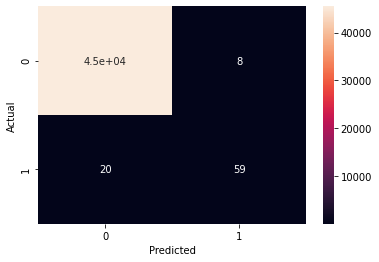

In [41]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

Predicted      0   1
Actual              
0          45482   8
1             20  59
------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.88      0.75      0.81        79

    accuracy                           1.00     45569
   macro avg       0.94      0.87      0.90     45569
weighted avg       1.00      1.00      1.00     45569

------------------------------------------------------------------------------


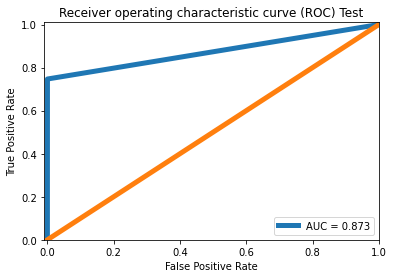

In [42]:
print(confusion_matrix)
print('------------------------------------------------------------------------------')
print(classification_report(y_test,y_pred))
print('------------------------------------------------------------------------------')
#Plotting the ROC-AUC Curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth = 5, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth = 5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC) Test')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Validation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.45      0.85      0.59        98

    accuracy                           1.00     56962
   macro avg       0.73      0.92      0.79     56962
weighted avg       1.00      1.00      1.00     56962



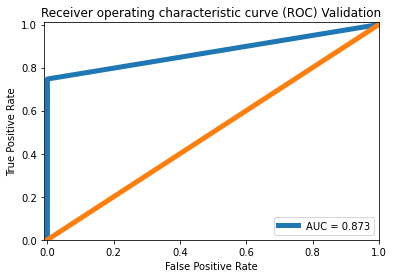

In [43]:
print(classification_report(y_val,y_val_pred))

#Plotting the ROC-AUC Curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth = 5, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth = 5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC) Validation')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
import xgboost as xgb

In [45]:
xgbclf=xgb.XGBClassifier(max_depth=8,learning_rate=0.5,use_label_encoder=False)
xgbclf.fit(x_train, y_train)

[13:55:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [46]:
# Testing
print('-----------------------------------------------------------------')
print('----------------------Testing---------------------------------')

y_pred = xgbclf.predict(x_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
print(classification_report(y_test, y_pred))
print(recall_score(y_test,y_pred))


print('-----------------------------------------------------------------')
print('----------------------Validation---------------------------------')
# Validation
y_val_pred = xgbclf.predict(x_val)
confusion_matrix = pd.crosstab(y_val, y_val_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
print(classification_report(y_val, y_val_pred))
print(recall_score(y_val,y_val_pred))


-----------------------------------------------------------------
----------------------Testing---------------------------------
Predicted      0   1
Actual              
0          45486   4
1             21  58
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.94      0.73      0.82        79

    accuracy                           1.00     45569
   macro avg       0.97      0.87      0.91     45569
weighted avg       1.00      1.00      1.00     45569

0.7341772151898734
-----------------------------------------------------------------
----------------------Validation---------------------------------
Predicted      0   1
Actual              
0          56855   9
1             22  76
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.78      0.83        98

    accuracy                           1.00     56962
   macr